# Training the hand classification model

In [ ]:
import os
import uuid
from datetime import datetime
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

package explanation:

These packages are essential for building a poker hand classification model due to their specialized functions:

- **os, uuid, datetime**: For file and directory management, generating unique identifiers, and timestamping, facilitating model saving and logging.
- **pickle**: Allows serialization of Python objects, enabling the saving and loading of trained models.
- **pandas**: Provides data structures and data analysis tools, crucial for manipulating and preparing the dataset.
- **tensorflow**: A powerful library for building and training deep learning models, used here to create the neural network for classification.
- **matplotlib, seaborn**: For data visualization, these libraries help in plotting graphs to analyze data and model performance.
- **numpy**: Adds support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays, essential for numerical computations.
- **scikit-learn (sklearn)**: Offers various machine learning algorithms, tools for model evaluation (like confusion_matrix), data splitting, and feature extraction, critical for preprocessing, training, evaluating classical models, and implementing strategies like K-Fold cross-validation.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold

In [ ]:
# Model Base Types
Sequential = tf.keras.models.Sequential

# Layers
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

# Optimizers
Adam = tf.keras.optimizers.Adam

# Helper Functions

In [ ]:
# Function reorders the data so that simular data represenations are near each other.
def reorder_data_cols(data):
    df = data.copy()
    dfc = df[['C1', 'C2', 'C3', 'C4', 'C5']]
    dfc.values.sort()
    df[['C1', 'C2', 'C3', 'C4', 'C5']] = dfc
    df = df[['C1', 'C2', 'C3', 'C4', 'C5', 'S1', 'S2', 'S3', 'S4', 'S5', 'Label']]
    return df

The objective of this model is to evaluate the potency of a poker hand, categorizing it into one of ten distinct types, which are denoted by integers ranging from 0 to 9. These integers represent various poker hands in ascending order of strength: "nothing," "one pair," "two pair," "three of a kind," "straight," "flush," "full house," "four of a kind," "straight flush," and "royal flush." This classification is based on the UCI dataset, which provides a structured framework for analyzing and determining the hierarchy of poker hands.


The UCI dataset encodes poker hands using integers, where card ranks are represented by integers 0 through 13, with 0 indicating the absence of a card, and suits are denoted by integers 0 through 4, again with 0 signifying no card. This encoding scheme, however, poses limitations for applications beyond the dataset's constraints, particularly for variants of poker such as Texas Hold'em. In Texas Hold'em, each player receives two private cards and shares access to five community cards, totaling seven potential cards per player. Given that the UCI dataset is structured around five-card hands, it does not directly accommodate the dynamics of Texas Hold'em, where players strategize based on a combination of seven cards. This discrepancy could lead to challenges in accurately modeling Texas Hold'em scenarios, potentially resulting in misclassifications and diminishing the model's effectiveness for this popular poker variant.

In [ ]:
# Function generates the confusion matrics data as a graphic
def print_cmat(cm, labels=None):
  """ Helper function to visualize confusion matrices. """
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt="g", cmap="YlGnBu", linewidths=0.5, ax=ax)

  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("True Labels")

  if labels:
      ax.xaxis.set_ticklabels(labels)
      ax.yaxis.set_ticklabels(labels)
  plt.show()

In [ ]:
train_data = pd.read_csv('poker-hand-training-true.data', header=None)
train_data.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Label']
train_data = reorder_data_cols(train_data)


test_data = pd.read_csv('poker-hand-testing.data', index_col=None)
test_data.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Label']
test_data = reorder_data_cols(test_data)

In [ ]:
train_data.describe()

,C1,C2,C3,C4,C5,S1,S2,S3,S4,S5,Label
count,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000
mean,2.600080,4.766693,6.995082,9.192923,11.374010,2.508756,2.497721,2.510236,2.495922,2.497321,0.621152
std,1.737962,2.256863,2.390171,2.262654,1.756516,1.116483,1.121767,1.123148,1.116009,1.118732,0.788361
min,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,3.000000,5.000000,8.000000,10.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,5.000000,7.000000,9.000000,12.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000
75%,3.000000,6.000000,9.000000,11.000000,13.000000,4.000000,4.000000,4.000000,3.000000,3.000000,1.000000
max,11.000000,12.000000,13.000000,13.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,9.000000


count: The total number of entries in the dataset, indicating that there are 25,010 poker hands recorded.

mean: The average value for each column. For card ranks (C1 through C5), the means increase progressively, which might reflect the sorting applied in reorder_data_cols function. The mean values for suits (S1 through S5) hover around 2.5, suggesting an even distribution across the 4 suits. The mean of Label is approximately 0.621, indicating the average hand classification in this dataset.

std (standard deviation): Measures the dispersion or variability from the mean. Higher values indicate greater variability. The std values for card ranks and suits suggest variability in the distribution of card ranks and suits across the hands, while the std for Label shows the spread of hand classifications.

min: The minimum value in each column. For ranks, the minimum starts at 1 (Ace or the lowest card), and for suits, the minimum is 1, indicating all suits are represented. The minimum label is 0, corresponding to the weakest hand classification.

25%, 50% (median), 75%: These represent the quartiles of the dataset. The 25% quartile shows the lower quartile, 50% is the median (middle value), and 75% is the upper quartile. These values provide insight into the distribution of card ranks, suits, and hand classifications. For instance, the median rank values increase across the cards, reflecting sorted card ranks.

max: The maximum values in each column, showing the highest card ranks and suit values observed, as well as the strongest hand classification (9) present in the dataset.

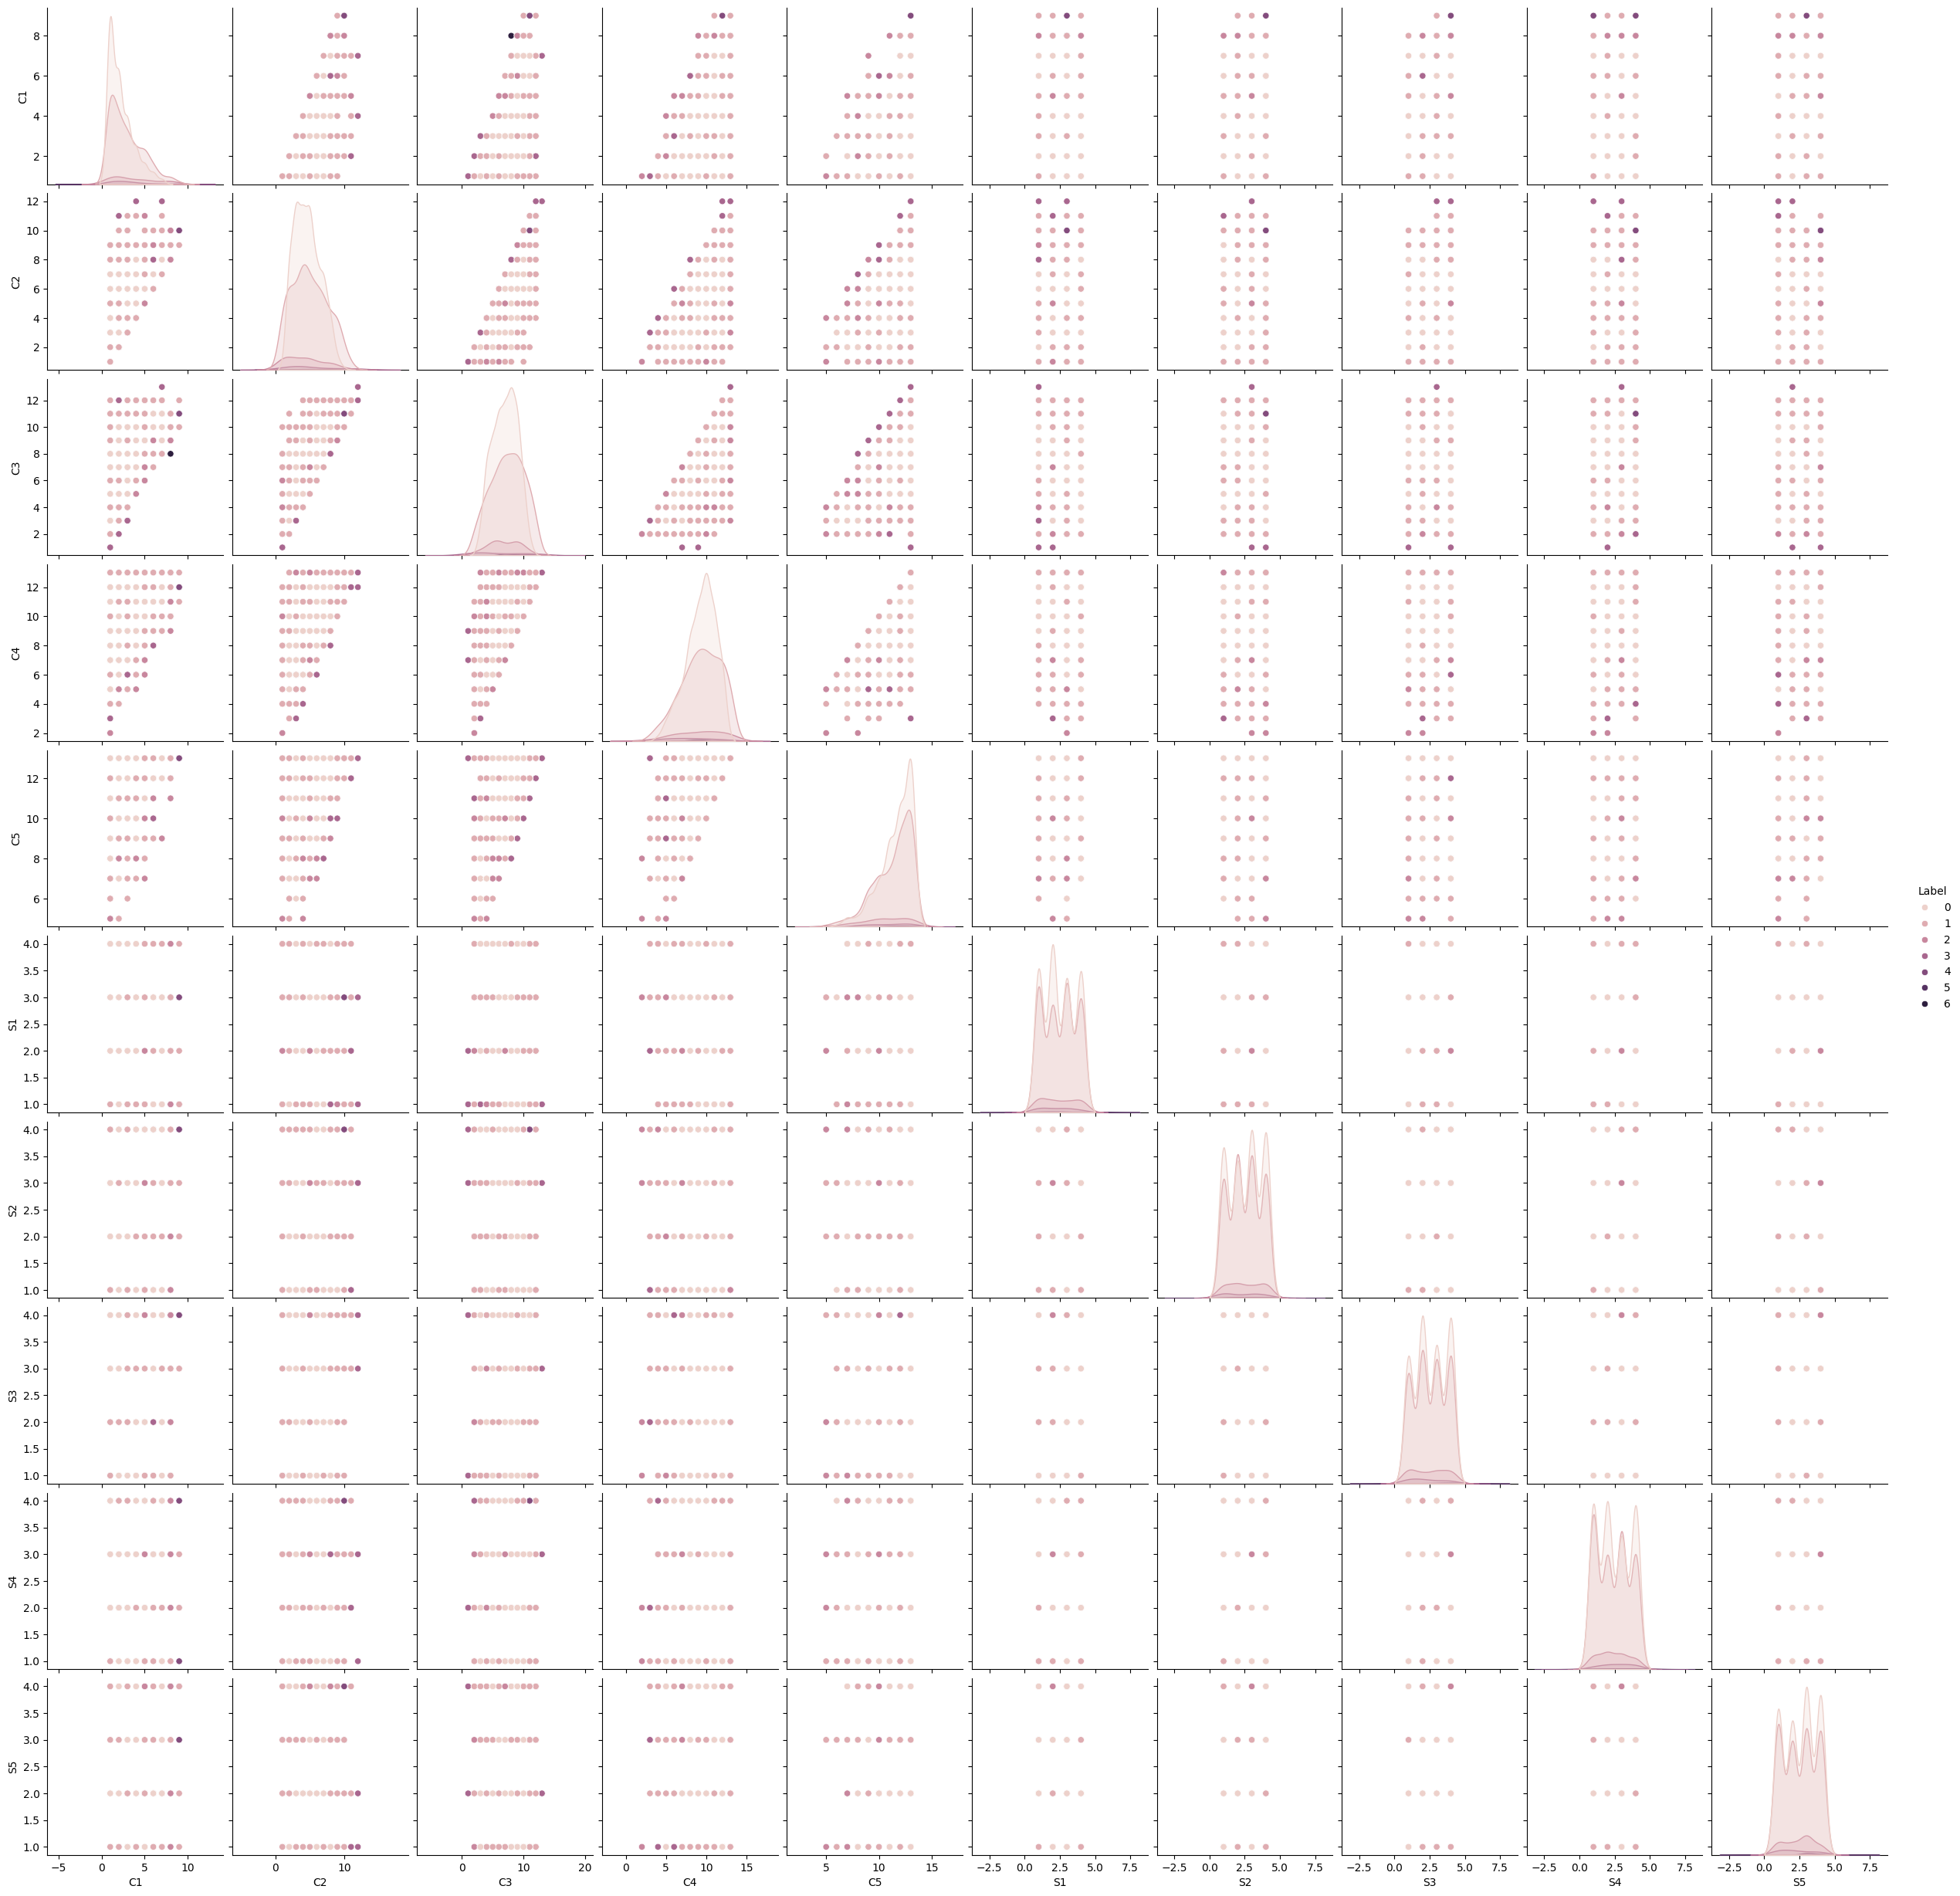

In [ ]:
# Increase the size of the plot for better readability
plt.figure(figsize=(20, 20))

# Use a sample of the data to speed up plotting and reduce overplotting
sampled_data = train_data.sample(1000)

# Select a subset of variables if needed, for example:
# selected_columns = ['C1', 'C2', 'C3', 'Label']
# sampled_data = sampled_data[selected_columns]

# Generate the pairplot
pair_plot = sns.pairplot(sampled_data, hue="Label", markers='.')
pair_plot.fig.set_size_inches(15,15)  # Increase the size of the pairplot

# Display the plot
plt.show()

For training and testing the University of California Irvine Poker Hand Data Set was used. This is a datasets contains 25,010 poker hands labeled with the corresponding hand strength.

<Axes: xlabel='Label', ylabel='Count'>

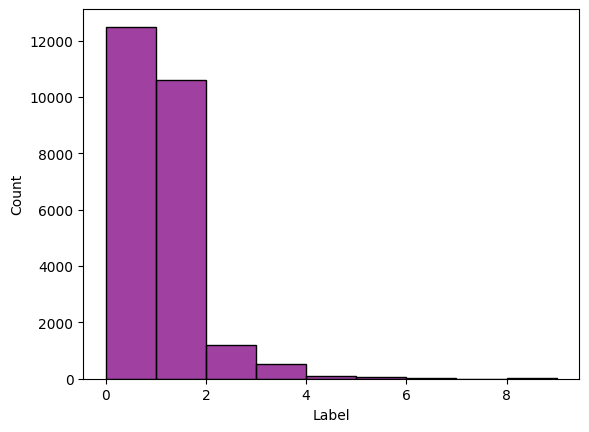

In [ ]:
sns.histplot(data=train_data['Label'], binwidth=1, color="purple")

The figure illustrates a significant imbalance in the dataset, showcasing a higher prevalence of weaker hands compared to stronger ones. This distribution aligns with the statistical probabilities inherent to poker hands, yet it introduces a bias that may inflate the model's accuracy. Specifically, the model's training is skewed towards recognizing weaker hands more frequently, potentially at the expense of accurately identifying rarer, stronger hands.

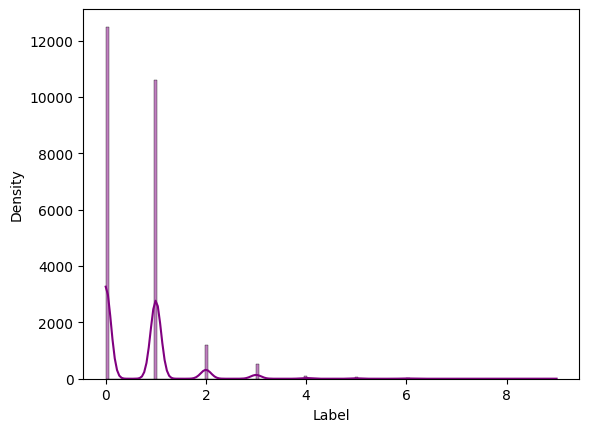

In [ ]:
sns.histplot(train_data['Label'], color="purple", kde=True)
plt.xlabel('Label')
plt.ylabel('Density')
plt.show()

The plot demonstrates a highly skewed distribution of poker hand labels. The peak at the leftmost part of the density plot suggests an overwhelming frequency of lower-ranked poker hands (such as "nothing" or "one pair"), which is consistent with the actual probabilities in poker where high-value hands are rarer. The rapid decline in density as the hand strength increases highlights the scarcity of strong hands like "full house," "four of a kind," or "straight flush."

In terms of data modeling, the visual suggests a potential class imbalance problem, which could lead a classification model to become biased towards predicting lower-ranked hands more accurately while performing less reliably on the less frequent, higher-ranked hands. Such imbalance might necessitate the implementation of strategies in model training that can handle disproportionate class frequencies, like weighted loss functions or resampling techniques.

# Prepare Test/Train Data

In [ ]:
# Group data based on feature and label status.

x_train = train_data[train_data.columns[:10]]
y_train = train_data[train_data.columns[10]]
x_test = test_data[test_data.columns[:10]]
y_test = test_data[test_data.columns[10]]

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

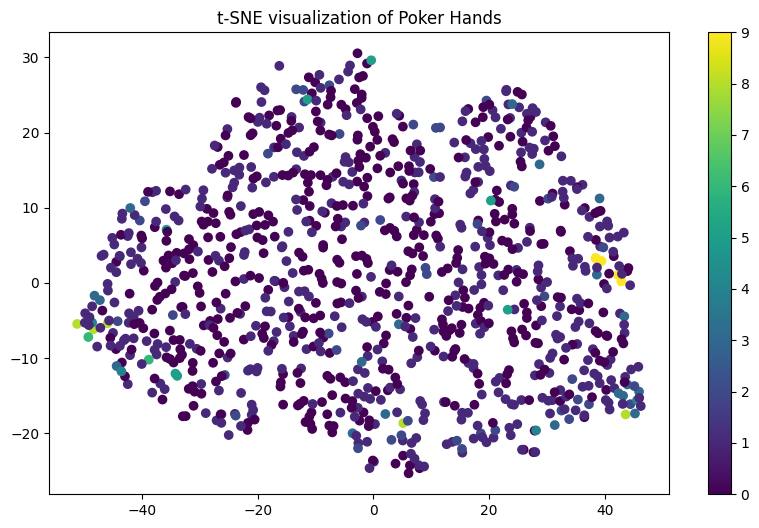

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x_train[:1000]) # Use a subset for faster computation

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:1000])
plt.colorbar()
plt.title("t-SNE visualization of Poker Hands")
plt.show()

Each point in the plot represents a poker hand from the dataset.
The location of each point is determined by the t-SNE algorithm such that points that are close in the original high-dimensional space are likely to be close in the 2-dimensional plot.
The color of each point corresponds to the hand's classification label (ranging from 0 to 9, which represents different types of poker hands).

# Test Classical Machine Learning Model

In [ ]:
criterion_options = ['entropy','gini']
splitter_options = ['best','random']
max_depth_options = [None,1,5,10,20,30,40,50,100,200]
min_samples_split_options = [2,5,7,10,20,40,50]
max_leaf_nodes_options = [None,2,5,7,10,20,30,50,100,200]

In [ ]:
# Calculate the total number of models to be generated based on the combination of hyperparameters
total_models_to_generate = len(criterion_options) * len(splitter_options) * len(max_depth_options) * len(min_samples_split_options) * len(max_leaf_nodes_options)
models_generated = 0

# Initialize an empty DataFrame to store the results of each model
tree_model_results_df = pd.DataFrame(columns=['criterion', 'splitter', 'max_depth', 'min_samples_split', 'max_leaf_nodes', 'accuracy'])
# Create a unique directory name based on the current date and time to store the serialized models
now_folder_name = datetime.now().strftime("%Y%m%d-%H%M%S")

# Iterate through each combination of hyperparameters
for criterion in criterion_options:
    for splitter in splitter_options:
        for max_depth in max_depth_options:
            for min_samples_split in min_samples_split_options:
                for max_leaf_nodes in max_leaf_nodes_options:
                    print(f'{models_generated} / {total_models_to_generate}')
                    # Initialize the Decision Tree model with the current set of hyperparameters
                    tree_model = DecisionTreeClassifier(random_state=1, criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, max_leaf_nodes=max_leaf_nodes)
                    # Train the model on the training data
                    tree_model.fit(x_train, y_train)
                    # Predict the labels for the test set
                    y_pred = tree_model.predict(x_test)
                    # Calculate the accuracy of the model
                    accuracy = accuracy_score(y_test, y_pred, normalize=True)
                    # Generate a unique filename for the current model
                    filename = 'tree_model-' + uuid.uuid4().hex + '.pickle'
                    # Create a dictionary to hold the model's parameters and accuracy
                    row = {
                        'criterion': criterion,
                        'splitter': splitter,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'max_leaf_nodes': max_leaf_nodes,
                        'accuracy': accuracy,
                        'filename': filename
                    }
                    # Use pd.concat to add the new row to the DataFrame instead of the deprecated append method
                    tree_model_results_df = pd.concat([tree_model_results_df, pd.DataFrame([row])], ignore_index=True)
                    # Increment the counter for models generated
                    models_generated += 1
                    # Construct the path where the model will be saved
                    save_path = f'pickled_models/{now_folder_name}/{filename}'
                    # Check if the directory exists, if not, create it
                    if not os.path.exists(f'pickled_models/{now_folder_name}'):
                        os.makedirs(f'pickled_models/{now_folder_name}')
                    # Serialize the model and save it to the specified path
                    pickle.dump(tree_model, open(save_path, 'wb'))

# Save the metadata of all generated models to a CSV file for later analysis
tree_model_results_df.to_csv(f'pickled_models/{now_folder_name}/model_meta_data.csv')

0 / 2800
1 / 2800
2 / 2800
3 / 2800
4 / 2800
5 / 2800
6 / 2800
7 / 2800
8 / 2800
9 / 2800
10 / 2800
11 / 2800
12 / 2800
13 / 2800
14 / 2800
15 / 2800
16 / 2800
17 / 2800
18 / 2800
19 / 2800
20 / 2800
21 / 2800
22 / 2800
23 / 2800
24 / 2800
25 / 2800
26 / 2800
27 / 2800
28 / 2800
29 / 2800
30 / 2800
31 / 2800
32 / 2800
33 / 2800
34 / 2800
35 / 2800
36 / 2800
37 / 2800
38 / 2800
39 / 2800
40 / 2800
41 / 2800
42 / 2800
43 / 2800
44 / 2800
45 / 2800
46 / 2800
47 / 2800
48 / 2800
49 / 2800
50 / 2800
51 / 2800
52 / 2800
53 / 2800
54 / 2800
55 / 2800
56 / 2800
57 / 2800
58 / 2800
59 / 2800
60 / 2800
61 / 2800
62 / 2800
63 / 2800
64 / 2800
65 / 2800
66 / 2800
67 / 2800
68 / 2800
69 / 2800
70 / 2800
71 / 2800
72 / 2800
73 / 2800
74 / 2800
75 / 2800
76 / 2800
77 / 2800
78 / 2800
79 / 2800
80 / 2800
81 / 2800
82 / 2800
83 / 2800
84 / 2800
85 / 2800
86 / 2800
87 / 2800
88 / 2800
89 / 2800
90 / 2800
91 / 2800
92 / 2800
93 / 2800
94 / 2800
95 / 2800
96 / 2800
97 / 2800
98 / 2800
99 / 2800
100 / 2800

In [ ]:
tree_model_results_df.sort_values('accuracy', ascending=False)

,criterion,splitter,max_depth,min_samples_split,max_leaf_nodes,accuracy,filename
1140,entropy,random,40,7,None,0.968648,tree_model-0727bc83e49746649801642065856f9f.pi...
1210,entropy,random,50,7,None,0.968648,tree_model-f71d2005b7244f58b7c64b1e32121d74.pi...
1350,entropy,random,200,7,None,0.968648,tree_model-435540cf4049431ca263b98a62001321.pi...
720,entropy,random,None,7,None,0.968648,tree_model-cd7e5e1e31d549ce98af54e2f8ee5d6b.pi...
1070,entropy,random,30,7,None,0.968648,tree_model-e6baad77bc4749e485c7351baf62ad6c.pi...
...,...,...,...,...,...,...,...
1071,entropy,random,30,7,2,0.529503,tree_model-3867f215f6a04ffd9ad49773675ab5b0.pi...
2190,gini,random,1,7,None,0.529503,tree_model-e1797c9939554089a982a05b2ae4bafa.pi...
2191,gini,random,1,7,2,0.529503,tree_model-be029838bd0042b3b3ca914fc5ab7f0e.pi...
2631,gini,random,50,20,2,0.529503,tree_model-857d54ca645843d795d433bf43f19cb2.pi...


from matplotlib import pyplot as plt
_df_0['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('criterion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('splitter').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('min_samples_split').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['splitter'].value_counts()
    for x_label, grp in _df_5.groupby('criterion')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('criterion')
_ = plt.ylabel('splitter')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['min_samples_split'].value_counts()
    for x_label, grp in _df_6.groupby('splitter')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('splitter')
_ = plt.ylabel('min_samples_split')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['criterion'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='accuracy', y='criterion', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['splitter'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='accuracy', y='splitter', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['min_samples_split'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='accuracy', y='min_samples_split', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

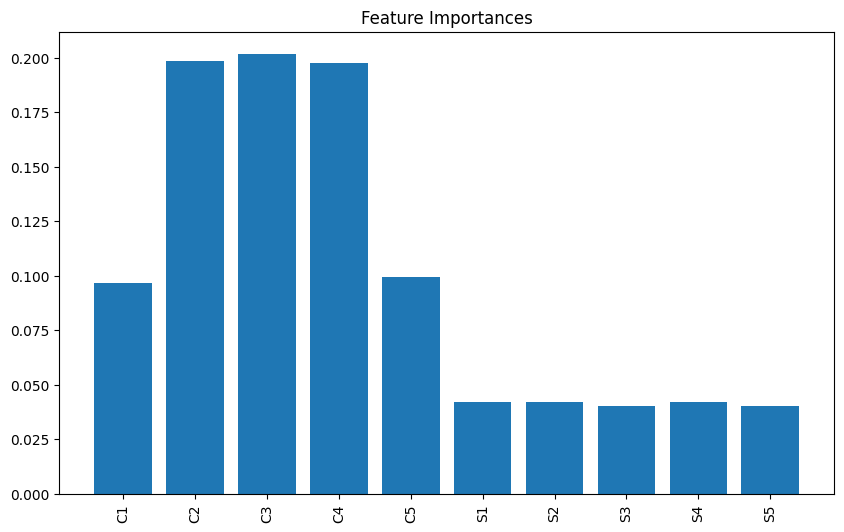

In [ ]:
# Keep x_train as DataFrame for now
x_train_df = train_data[train_data.columns[:10]]  # Keeping it as DataFrame
y_train = train_data[train_data.columns[10]]

# Now, when plotting, you can directly use x_train_df.columns
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_df, y_train)  # Use DataFrame directly
importances = rf.feature_importances_

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), x_train_df.columns, rotation=90)  # Use x_train_df.columns directly
plt.show()

# Convert to numpy arrays if needed for other models or processing steps afterwards
x_train = x_train_df.to_numpy()

criterion: entropy | splitter: random | max_depth: 40 | min_samples_split: 7 | max_leaf_nodes: None | accuracy: 0.9686479686479686


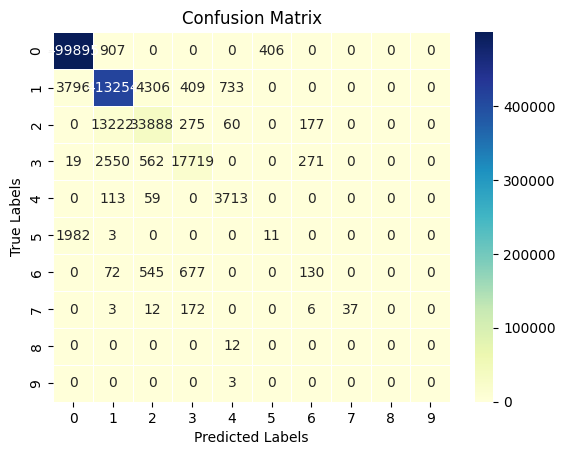

criterion: entropy | splitter: random | max_depth: 50 | min_samples_split: 7 | max_leaf_nodes: None | accuracy: 0.9686479686479686


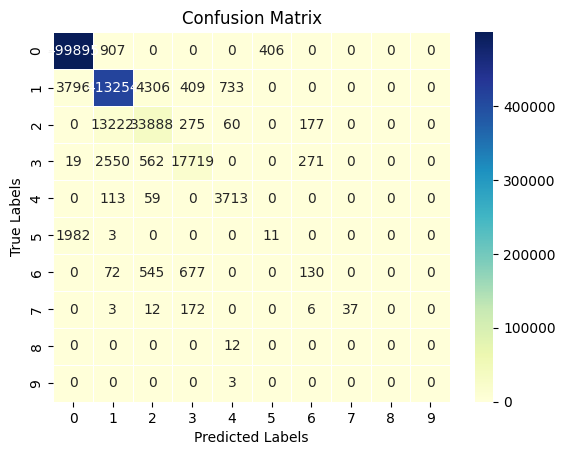

criterion: entropy | splitter: random | max_depth: 200 | min_samples_split: 7 | max_leaf_nodes: None | accuracy: 0.9686479686479686


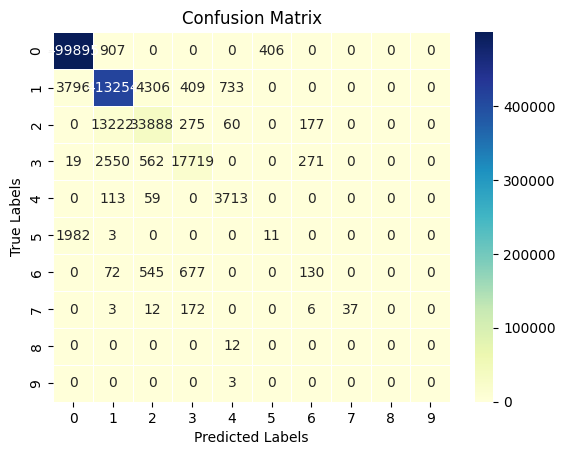

criterion: entropy | splitter: random | max_depth: None | min_samples_split: 7 | max_leaf_nodes: None | accuracy: 0.9686479686479686


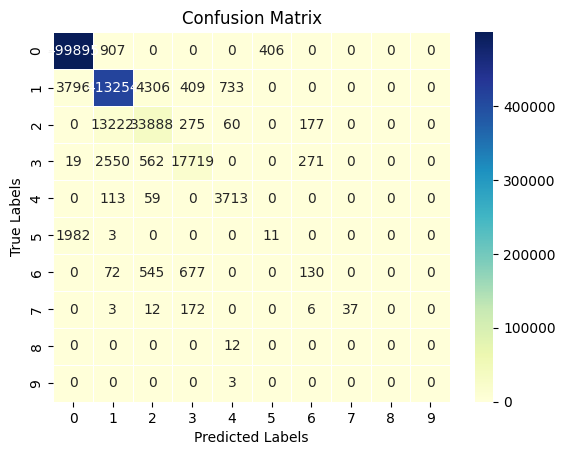

criterion: entropy | splitter: random | max_depth: 30 | min_samples_split: 7 | max_leaf_nodes: None | accuracy: 0.9686479686479686


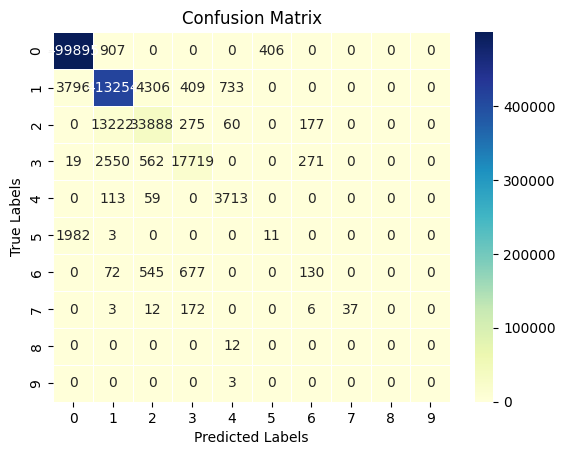

In [ ]:
for index in range(5):
    top_model_stats = tree_model_results_df.sort_values('accuracy', ascending=False).iloc[index]
    criterion = top_model_stats['criterion']
    splitter = top_model_stats['splitter']
    max_depth = top_model_stats['max_depth']
    # Corrected from 'min_samples' to 'min_samples_split'
    min_samples_split = top_model_stats['min_samples_split']  # Corrected key
    max_leaf_nodes = top_model_stats['max_leaf_nodes']
    accuracy = top_model_stats['accuracy']
    tree_model = DecisionTreeClassifier(random_state=1, criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, max_leaf_nodes=max_leaf_nodes)
    tree_model.fit(x_train, y_train)
    y_pred = tree_model.predict(x_test)

    cmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print(f'criterion: {criterion} | splitter: {splitter} | max_depth: {max_depth} | min_samples_split: {min_samples_split} | max_leaf_nodes: {max_leaf_nodes} | accuracy: {accuracy}')
    print_cmat(cmat)

# Test Deep Learning Model

In [ ]:
# Layer Creation

input_layer = Dense(10, activation="linear")

dense_layer_1 = Dense(30, activation="relu")

dropout_layer_1 = Dropout(.05)

dense_layer_2 = Dense(20, activation="relu")

dropout_layer_2 = Dropout(.05)

dense_layer_3 = Dense(15, activation="relu")

output_layer = Dense(10, activation="linear")

In [ ]:
# Sequential Model Architecture Design
model = Sequential()

# Add All Initialized Layers in Effective Sequence
model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_layer_1)
model.add(dense_layer_2)
model.add(dropout_layer_2)
model.add(dense_layer_3)
model.add(output_layer)

In [ ]:
# Define Adam optimization with updated parameter
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
batch_size, epochs = 5000, 25

# Fit Learning Model Using Training Data and Configured Hyperparameters
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                   verbose=True)

# Get Model Summary for Confirmation
model.summary()

Epoch 1/25
6/6 [==============================] - 2s 13ms/step - loss: 10.6014 - accuracy: 0.0397
Epoch 2/25
6/6 [==============================] - 0s 10ms/step - loss: 9.7372 - accuracy: 0.0885
Epoch 3/25
6/6 [==============================] - 0s 9ms/step - loss: 9.6013 - accuracy: 0.0786
Epoch 4/25
6/6 [==============================] - 0s 11ms/step - loss: 9.5029 - accuracy: 0.0485
Epoch 5/25
6/6 [==============================] - 0s 11ms/step - loss: 9.4450 - accuracy: 0.0308
Epoch 6/25
6/6 [==============================] - 0s 10ms/step - loss: 9.4143 - accuracy: 0.0241
Epoch 7/25
6/6 [==============================] - 0s 10ms/step - loss: 9.4233 - accuracy: 0.0181
Epoch 8/25
6/6 [==============================] - 0s 12ms/step - loss: 9.4070 - accuracy: 0.0172
Epoch 9/25
6/6 [==============================] - 0s 11ms/step - loss: 9.4115 - accuracy: 0.0186
Epoch 10/25
6/6 [==============================] - 0s 12ms/step - loss: 9.4019 - accuracy: 0.0241
Epoch 11/25
6/6 [============

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {accuracy}\nLoss: {loss:.4f}")

31250/31250 [==============================] - 49s 2ms/step - loss: 2.9797 - accuracy: 0.0337
Accuracy: 0.03373103216290474
Loss: 2.9797


In [ ]:
# Get Our Predicted Labels
y_pred = np.argmax(model.predict(x_test), axis=1)

31250/31250 [==============================] - 45s 1ms/step


In [ ]:
# Create Simple Confusion Matrix as 2D Array
cmat = confusion_matrix(y_true=y_test,
                        y_pred=y_pred)

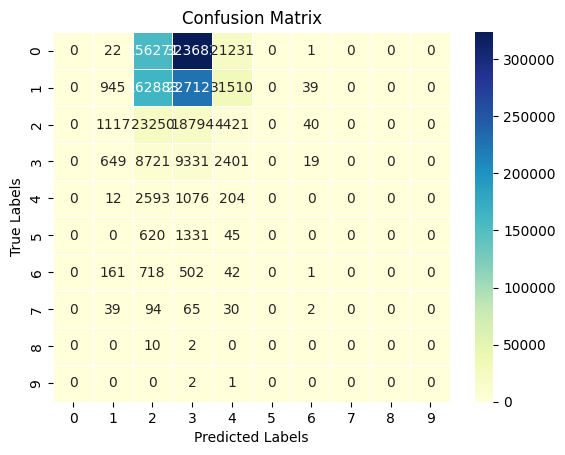

In [ ]:
cmat = confusion_matrix(y_true=y_test,
                        y_pred=y_pred)
print_cmat(cmat)

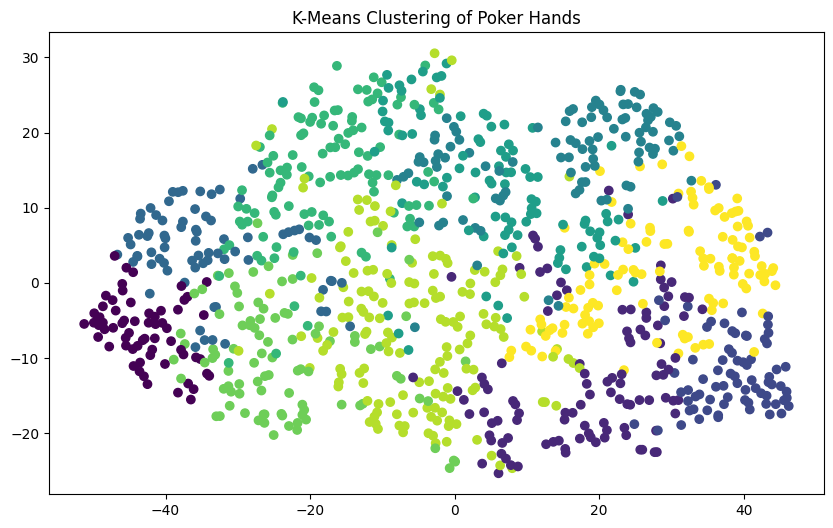

In [ ]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
clusters = kmeans.fit_predict(x_train)

# Assuming you've already applied t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters[:1000])  # Using the t-SNE results for visualization
plt.title("K-Means Clustering of Poker Hands")
plt.show()